# 1 - Introduction

## 1.1 - Dependencies

### 1.1.1 - External libraries

In [ ]:
colab = False

try:
    from google.colab import drive
    colab = True
    import os
    import sys
    drive.mount('/content/drive/')
    %cd /content/drive/MyDrive/prl_seg
except ImportError as e:
    pass

if colab:
    ! pip install monai
    ! pip install SimpleITK


In [18]:

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import SimpleITK as sitk
import torch
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from scipy.stats import wasserstein_distance
import numpy as np
import pandas as pd
import math

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, GeneralizedWassersteinDiceLoss, GeneralizedDiceLoss
from monai.transforms import (
    SpatialCrop
)

### 1.1.2 - Local libraries

In [19]:
%reload_ext autoreload
%autoreload 2
import pylib.nifti as nii
from pylib import visualization as vis
from pylib.models import unet
from pylib.datasets import dataset, star
from pylib.datasets.lazy_dataset import LazyDataset
import pylib.imaging.transforms as transforms
import pylib.imaging.lesion_tools as lt
from pylib.evaluation import evaluation
from config import *
import os

# 2 - Data vis

The following data was kindly provided by Penn state University: 

* Central line of PRLs
* Preprocessed* FLAIR image
* Preprocessed* T2*-PHASE image
* Preprocessed*T1 image
* Segmentation mask of all lesions


*and was preprocessed with the following steps by Lou et al. (2021):

* Phase unwrapping of T2*-images.
* N4 inhomogeneity correction.
* Registration of T1 and FLAIR images to phase space.
* Skullstripping.
* WhiteStripe normalization. 

In [20]:
EXAMPLE_PATIENT_ID = "001"
example_idx = 96

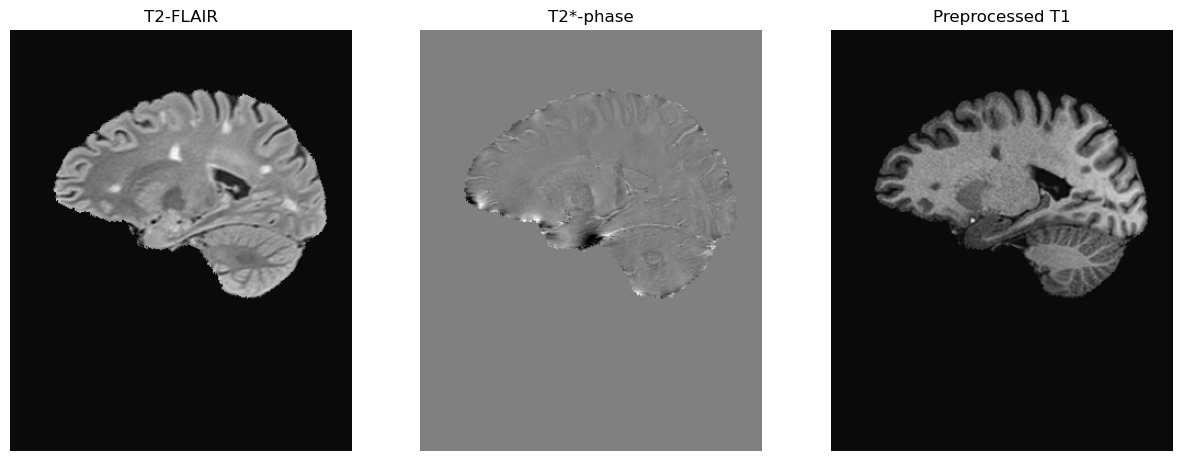

In [21]:
plt.close('all')
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15, 10))
vis.plot_nifti_on_ax(axs[0], img = f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}/{FLAIR}", title = "T2-FLAIR", k_rot90=2, idx=example_idx)
vis.plot_nifti_on_ax(axs[1], img = f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}/{PHASE}", title = "T2*-phase", k_rot90=2, idx=example_idx)
vis.plot_nifti_on_ax(axs[2], img = f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}/{T1}", title = "Preprocessed T1", k_rot90=2, idx=example_idx)
plt.show()

# 3 - Preprocessing

## 3.1 - Dataset analyzation


In [5]:
train_dataset = torch.load(PATH_VISUALIZATION_DATASET, weights_only=False)

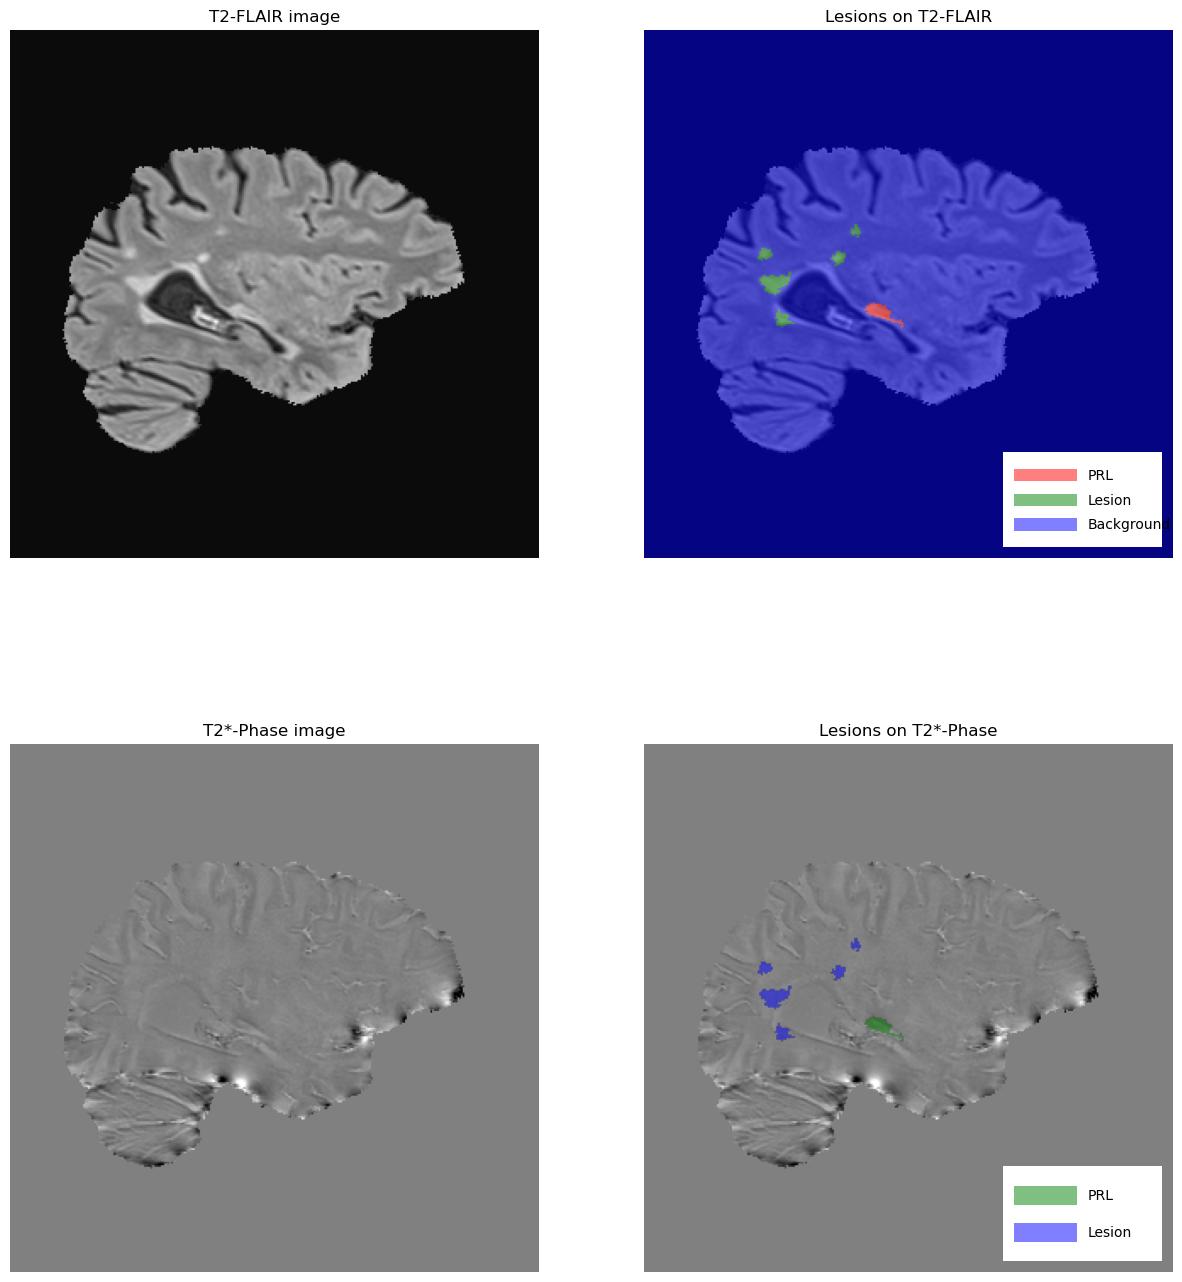

In [6]:
EXAMPLE_TRAIN_IDX = 11
img, label = train_dataset[EXAMPLE_TRAIN_IDX]

plt.close('all')
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 17))
vis.plot_nifti_on_ax(axs[0][0], img = img[CHANNEL_FLAIR], title = "T2-FLAIR image")
vis.plot_nifti_on_ax(axs[0][1], img = img[CHANNEL_FLAIR], mask=label, title = "Lesions on T2-FLAIR", mask_legend=["Background", "Lesion", "PRL"], drop_first_label_channel=False)
vis.plot_nifti_on_ax(axs[1][0], img = img[CHANNEL_PHASE], title = "T2*-Phase image")
vis.plot_nifti_on_ax(axs[1][1], img = img[CHANNEL_PHASE], mask=label, title = "Lesions on T2*-Phase", mask_legend=["Lesion", "PRL"])
plt.show()

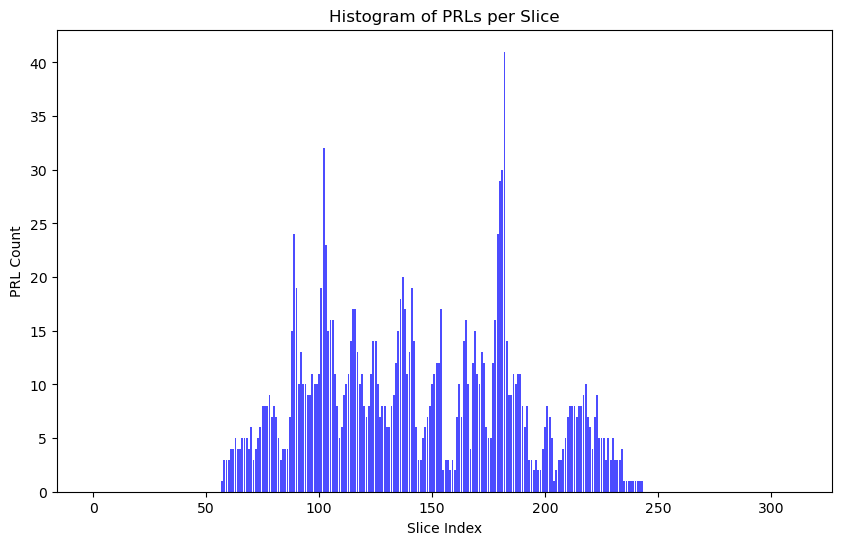

tensor(57) tensor(243)
Total PRLs:  1586


In [7]:
all_prls = [dataset.process_patient(os.path.join(ORIG_PATH, file), fnames = [PHASE_UNWRAPPED_UBMASK])[0] for file in os.listdir(ORIG_PATH)]

per_z_prls = [torch.sum(prl, dim=(1, 2)).squeeze(0) for prl in all_prls]
per_z_prls = torch.sum(torch.stack(per_z_prls), dim=0)

plt.close('all')
plt.figure(figsize=(10, 6))
plt.bar(range(len(per_z_prls)), per_z_prls.numpy(), color='blue', alpha=0.7)
plt.xlabel('Slice Index')
plt.ylabel('PRL Count')
plt.title('Histogram of PRLs per Slice')
plt.show()

indices = torch.where(per_z_prls > 0)[0]
print(torch.min(indices), torch.max(indices))

print("Total PRLs: ", torch.sum(per_z_prls).item())

In [ ]:
RUN_LESION_STATS = False
if RUN_LESION_STATS:
    all_lesions = [dataset.process_patient(os.path.join(ORIG_PATH, file), fnames = [SEG_2_PHASE])[0] for file in os.listdir(ORIG_PATH)]

    lesion_count = [len(lt.get_clusters_3d(lesion.squeeze(0))) for lesion in all_lesions]
    prl_count = [len(lt.get_clusters_3d(prl.squeeze(0))) for prl in all_prls]

    print("Total lesions: ", sum(lesion_count))
    print("Average lesions per patient: ", sum(lesion_count) / len(lesion_count))
    print("Max lesions per patient: ", max(lesion_count))
    print("Min lesions per patient: ", min(lesion_count))


    print("Total PRLs: ", sum(prl_count))
    print("Average PRLs per patient: ", sum(prl_count) / len(prl_count))
    print("Max PRLs per patient: ", max(prl_count))
    print("Min PRLs per patient: ", min(prl_count))

Total lesions:  986
Average lesions per patient:  75.84615384615384
Max lesions per patient:  157
Min lesions per patient:  38
Total PRLs:  105
Average PRLs per patient:  8.076923076923077
Max PRLs per patient:  27
Min PRLs per patient:  3


In [ ]:
all_lesions = dataset.process_patient(os.path.join(ORIG_PATH, EXAMPLE_PATIENT_ID), fnames = [SEG_2_PHASE])[0]
all_prls = dataset.process_patient(os.path.join(ORIG_PATH, EXAMPLE_PATIENT_ID), fnames = [PHASE_UNWRAPPED_UBMASK])[0]


lesions_1 = lt.get_clusters_3d(all_lesions.squeeze(0))
prls_1 = zip(*torch.nonzero(all_prls.squeeze(0), as_tuple=True))

prls_1 = lt.get_overlapping_clusters_from_central_lines(lesions_1, prls_1)
mask = torch.zeros((2, *all_prls.shape[1:]))


for lesion in lesions_1:
    for coord in lesion:
        mask[0, coord[0], coord[1], coord[2]] = 1
for prl in prls_1:
    for coord in prl:
        mask[1, coord[0], coord[1], coord[2]] = 1

mask[0][mask[1] > 0] = 0

lesions_2 = lt.get_clusters_3d(mask[0])
prls_2 = lt.get_clusters_3d(mask[1])


#prls = [lt.get_overlapping_clusters_from_central_lines(lesion, prl) for prl, lesion in zip(prls, lesions)]
print("Lesions: ", len(lesions_1), "PRLs: ", len(prls_1))
print("Lesions 2: ", len(lesions_2), "PRLs 2: ", len(prls_2))


Lesions:  47 PRLs:  128
Lesions 2:  36 PRLs 2:  11


In [9]:
print(all_lesions[0].shape, all_prls[0].shape)
print(len(all_lesions), len(all_prls))

torch.Size([1, 256, 312, 312]) torch.Size([1, 256, 312, 312])
13 13


# 3.2 - MS-Lesion Segmentation Dataset

In [10]:
CREATE_SEG_DATASET = False
if CREATE_SEG_DATASET:
    dataset.create_lesion_dataset(
        patient_dirs=[os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)], 
        flair_fname=FLAIR, 
        phase_fname=PHASE, 
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK, 
        save_seg_train_path=PATH_TRAIN_LESION_SEG_DATASET, 
        save_seg_val_path=PATH_VAL_LESION_SEG_DATASET,
        save_seg_test_path=PATH_TEST_LESION_SEG_DATASET,
        num_val=1,
        num_test=1
        )

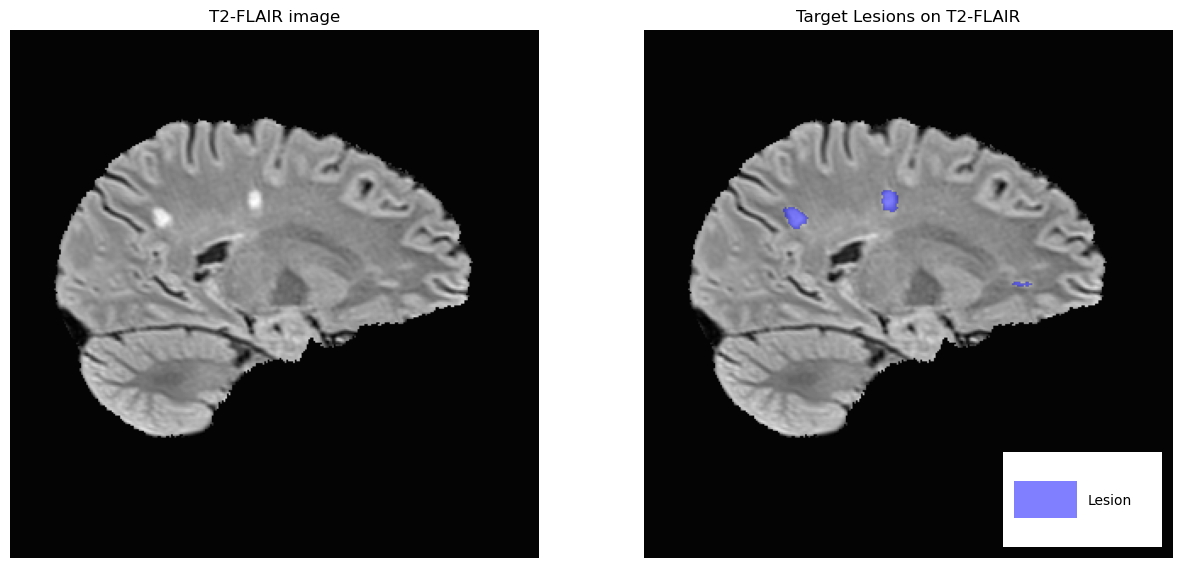

In [11]:
EXAMPLE_TRAIN_IDX = 150
prl_seg_train_dataset = torch.load(PATH_TRAIN_LESION_SEG_DATASET, weights_only=False)
img, label = prl_seg_train_dataset[EXAMPLE_TRAIN_IDX]

plt.close('all')
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (15, 10))
vis.plot_nifti_on_ax(axs[0], img = img[0], title = "T2-FLAIR image")
vis.plot_nifti_on_ax(axs[1], img = img[0], mask=label, title = "Target Lesions on T2-FLAIR", mask_legend=["Lesion"], drop_first_label_channel=False)
plt.show()

# 3.3 - PRL Classification Dataset

In [12]:
example_phase, example_lesions, example_prl = dataset.process_patient(f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}", fnames = [PHASE, SEG_2_PHASE, PHASE_UNWRAPPED_UBMASK])

example_phase = example_phase[0]
example_lesions = example_lesions[0]
example_prl = example_prl[0]

imgs, labels = dataset.process_prl_tensors_to_sub_images_2d(
    example_phase, example_lesions, example_prl, 
    img_size=[64, 64],
    lesion_expansion=3,
    min_inter_lesion_distance=MIN_SUB_LESION_DISTANCE,
    mask = True
)

print(imgs[0].shape)


n_cols = 6
n_rows = 2


torch.Size([1, 64, 64])


[82, 86, 87, 90, 91, 95, 96, 100, 101, 105, 106, 110, 114, 137, 138, 139, 142, 147, 155, 162, 164, 173, 178, 182, 183, 184, 186, 190, 191, 192, 195, 200, 208, 215, 220, 223, 226, 228, 235, 320, 324, 327, 332, 337, 341, 345, 348, 351, 353, 354, 356, 357, 359, 360, 362, 364, 366, 368, 369, 371, 373, 376, 379, 382, 385, 387, 389, 391, 395, 405]


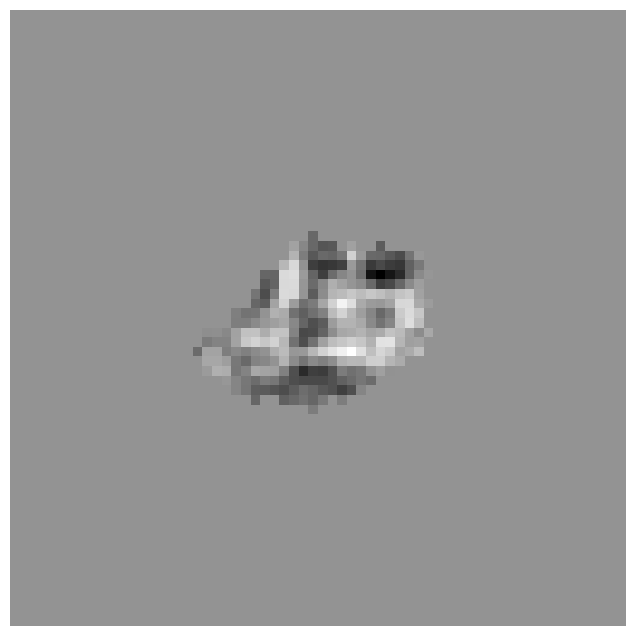

In [13]:
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 8))
prl_indices = [i for i in range(len(imgs)) if labels[i] == 1]
print(prl_indices)
vis.plot_nifti_on_ax(axs, img = imgs[prl_indices[6]][0])


In [14]:
CREATE_CLASS_DATASET = False
if CREATE_CLASS_DATASET:
    dataset.create_prl_class_dataset_3d(
        patient_dirs = [os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)],
        phase_fname=PHASE,
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK, 
        img_size=SUB_LESION_IMG_SIZE,
        min_inter_lesion_distance=MIN_SUB_LESION_DISTANCE,
        lesion_expansion=3,
        mask=False,
        save_class_train_path=PATH_3D_TRAIN_PRL_CLASS_DATASET,
        save_class_val_path=PATH_3D_VAL_PRL_CLASS_DATASET,
        save_class_test_path=PATH_3D_TEST_PRL_CLASS_DATASET,
        num_val_samples=1,
        num_test_samples=1
    )

# 3.4 - SWI data

https://pmc.ncbi.nlm.nih.gov/articles/PMC3805391/

Mean of T2*-phase: -1.7871249914169312, Std of T2*-phase: 28.0258731842041, Min: -472.5318603515625, Max: 469.0610046386719
Mean of T2*-phase high-pass filtered: -1.7871249914169312, Std of T2*-phase high-pass filtered: 28.0258731842041, Min: -472.5318603515625, Max: 469.0610046386719


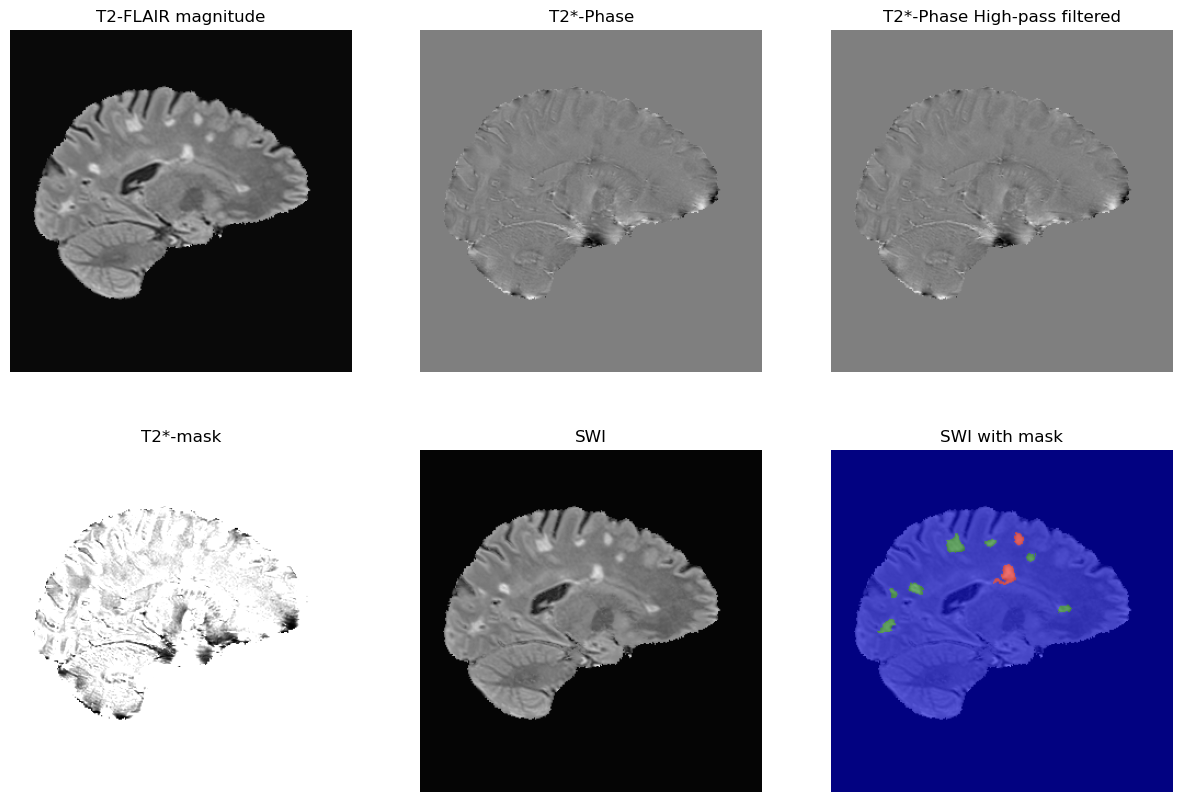

In [15]:

example_idx = 100
phase, mag, mask, prl_mask = dataset.process_patient(f"{ORIG_PATH}/{EXAMPLE_PATIENT_ID}", fnames = [PHASE, FLAIR, SEG_2_PHASE, PHASE_UNWRAPPED_UBMASK])


high_pass_phase = phase.clone()


mask[mask > 0] = 1
prl_mask[prl_mask > 0] = 1

mask, prl_mask_growed = lt.grow_all_regions(mask.squeeze(0), prl_mask.clone().squeeze(0))

prl_mask_growed = prl_mask_growed.to(torch.float32)
mask[prl_mask_growed > 0] = 0
background_mask = 1 - mask

mask = torch.stack([background_mask, mask, prl_mask_growed], dim=0)

#high_pass_phase = high_pass_phase / high_pass_phase.max() * math.pi

## SIEMENS is left-handed, so we are interested in the positive phase
phase_mask = transforms.create_phase_mask(high_pass_phase, n = 4)

flair_s = phase_mask * mag


print(f"Mean of T2*-phase: {torch.mean(phase)}, Std of T2*-phase: {torch.std(phase)}, Min: {torch.min(phase)}, Max: {torch.max(phase)}")
print(f"Mean of T2*-phase high-pass filtered: {torch.mean(high_pass_phase)}, Std of T2*-phase high-pass filtered: {torch.std(high_pass_phase)}, Min: {torch.min(high_pass_phase)}, Max: {torch.max(high_pass_phase)}")

        
phase = phase.squeeze(0)
high_pass_phase = high_pass_phase.squeeze(0)
mag = mag.squeeze(0)
flair_s = flair_s.squeeze(0)
phase_mask = phase_mask.squeeze(0)

fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 10))


vis.plot_nifti_on_ax(axs[0][0], img = mag[example_idx], title = "T2-FLAIR magnitude")
vis.plot_nifti_on_ax(axs[0][1], img = phase[example_idx], title = "T2*-Phase")
vis.plot_nifti_on_ax(axs[0][2], img = high_pass_phase[example_idx], title = "T2*-Phase High-pass filtered")
vis.plot_nifti_on_ax(axs[1][0], img = phase_mask[example_idx], title = "T2*-mask")
vis.plot_nifti_on_ax(axs[1][1], img = flair_s[example_idx], title = "SWI")
vis.plot_nifti_on_ax(axs[1][2], img = flair_s[example_idx], mask = mask[:, example_idx], drop_first_label_channel=False, title = "SWI with mask")
fig.savefig("output/images/flair_star.png")

In [ ]:
CREATE_SWI_DATASET = True
if CREATE_SWI_DATASET:

    patient_dirs = [os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)]
    
    star.create_star_dataset(
        patient_dirs = patient_dirs,
        flair_fname=FLAIR,
        phase_fname=PHASE,
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK,
        save_train_val_dir=DIR_TRAIN_SWI_DATASET,
        save_test_dir=DIR_TEST_SWI_DATASET,
        num_test_samples=2,
        crop = SpatialCrop(roi_center = (256 // 2, 312 // 2, 312 // 2 - 50), roi_size = (256 - 64, 304, 304)), #Found by visual inspection
        augment=True
    )


Output()

In [18]:
CREATE_SWI_DATASET_3D = True
if CREATE_SWI_DATASET_3D:

    patient_dirs = [os.path.join(ORIG_PATH, p) for p in os.listdir(ORIG_PATH)]
    
    star.create_star_dataset_3d(
        patient_dirs = patient_dirs,
        flair_fname=FLAIR,
        phase_fname=PHASE,
        lesion_fname=SEG_2_PHASE,
        prl_fname=PHASE_UNWRAPPED_UBMASK,
        save_train_dir=DIR_TRAIN_SWI_DATASET_3D,
        save_val_dir=DIR_VAL_SWI_DATASET_3D,
        save_test_dir=DIR_TEST_SWI_DATASET_3D,
        num_val_samples=1,
        num_test_samples=2
    )

Output()

In [1]:
train_star_data_3d = LazyDataset(DIR_TRAIN_SWI_DATASET_3D)
mag, phase, mask = train_star_data_3d[0]
print(mag.shape, phase.shape, mask.shape)
vis.run_app(
    image_3d=vis.Image3D(mag[1220], image_config=vis.ImageConfig3D.CHWD)
)

NameError: name 'LazyDataset' is not defined

torch.Size([312, 1, 256, 312]) torch.Size([312, 1, 256, 312]) torch.Size([312, 3, 256, 312])


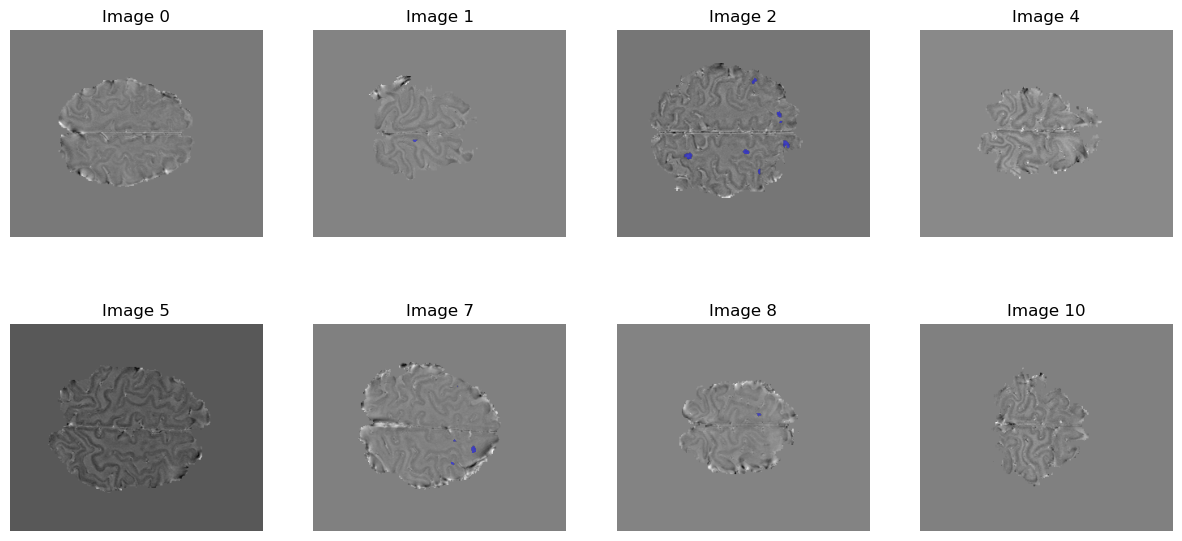

In [12]:
train_star_data = LazyDataset(DIR_TRAIN_SWI_DATASET)
mag, phase, mask = train_star_data[0]

print(mag.shape, phase.shape, mask.shape)

n_rows = 2
n_cols = 4
example_idx = 70

plt.close('all')
fig, axs = plt.subplots(ncols = n_cols, nrows = n_rows, figsize = (15, 7))
for i, (idx, ax) in enumerate( zip(np.linspace(0, len(train_star_data)-1, n_rows * n_cols, dtype=int), axs.flatten())):
    img, phase, mask = train_star_data[idx]
    #ax.imshow(img.numpy(), cmap='gray')
    vis.plot_nifti_on_ax(ax, img = phase[example_idx, 0], mask=mask[example_idx], drop_first_label_channel=True, title = f"Image {idx}")

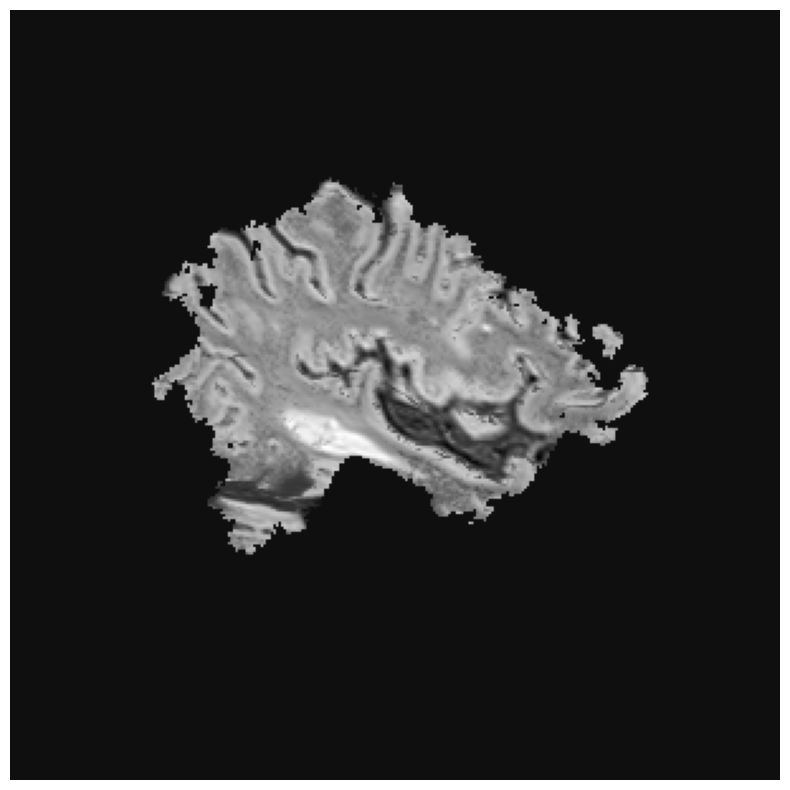

In [ ]:
example_idx = 4
img, phase, mask = train_star_data[10]
img = img[example_idx].squeeze(0)
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 10))
vis.plot_nifti_on_ax(axs, img = img)
plt.savefig("output/images/augmentation_flip", bbox_inches='tight')

torch.Size([312, 3, 256, 312])


Exception in thread Thread-84:
Traceback (most recent call last):
  File "c:\Users\adria\anaconda3\envs\ml\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\adria\anaconda3\envs\ml\lib\threading.py", line 1378, in run
    self.function(*self.args, **self.kwargs)
  File "c:\Users\adria\dev\prl_seg\pylib\visualization.py", line 431, in update_plot
    canvas.draw()
  File "c:\Users\adria\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 10, in draw
    super().draw()
  File "c:\Users\adria\anaconda3\envs\ml\lib\site-packages\matplotlib\backends\backend_agg.py", line 387, in draw
    self.figure.draw(self.renderer)
  File "c:\Users\adria\anaconda3\envs\ml\lib\site-packages\matplotlib\artist.py", line 95, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "c:\Users\adria\anaconda3\envs\ml\lib\site-packages\matplotlib\artist.py", line 72, in draw_wrapper
    return draw(artist, renderer)
  File "c:\Users\

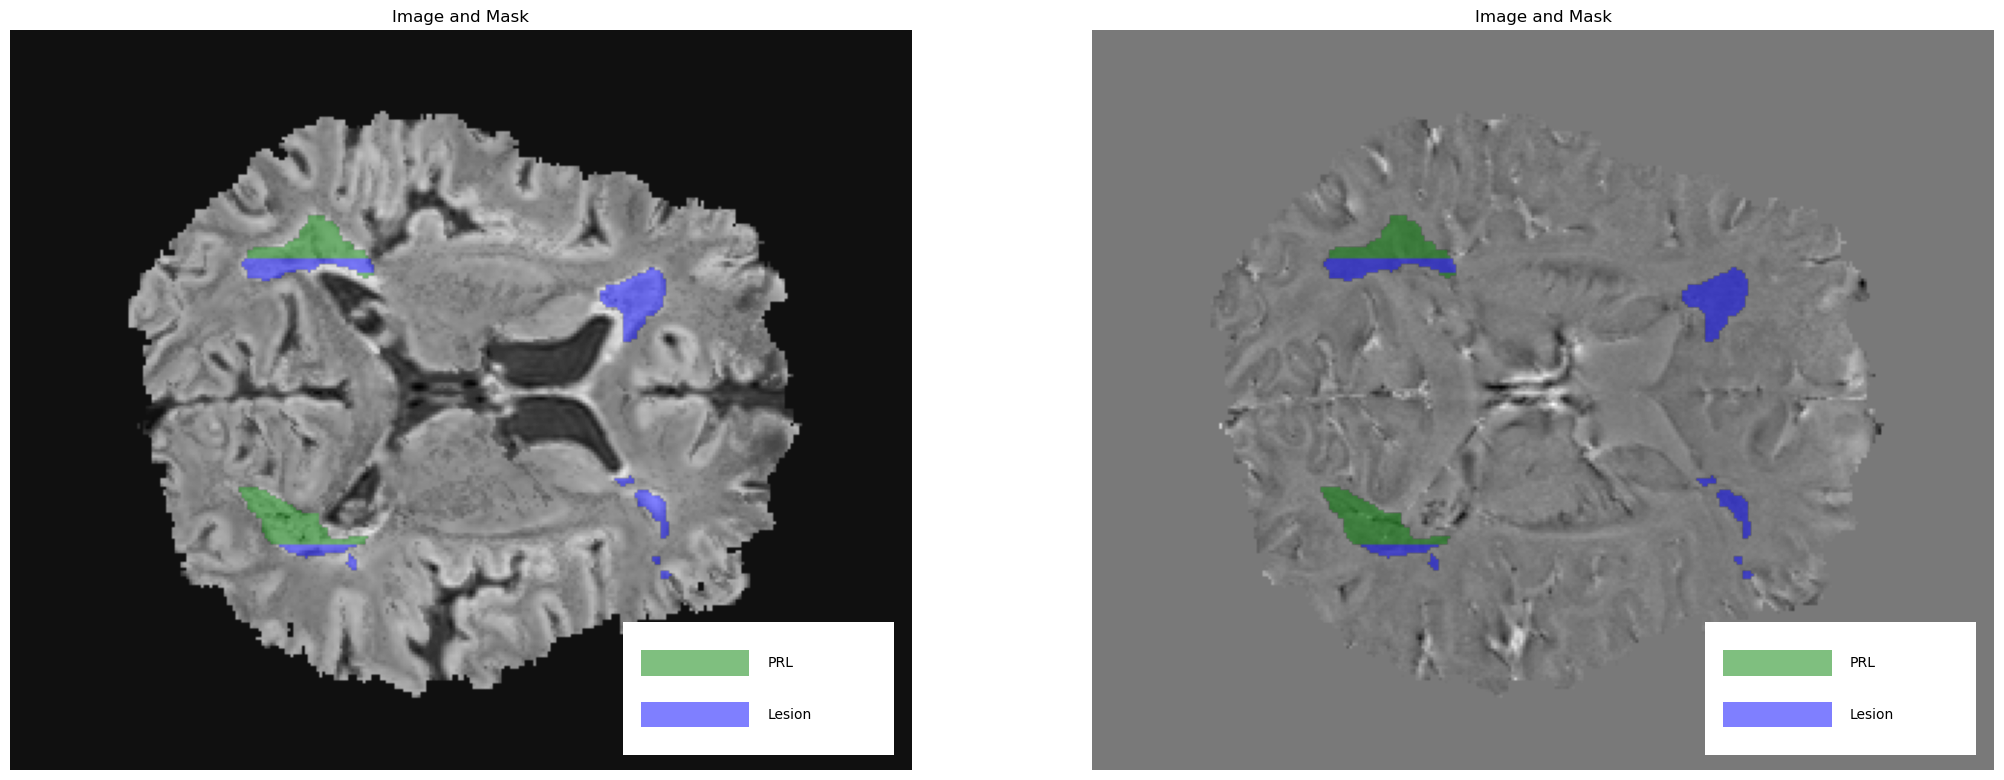

In [38]:
img, phase, mask = train_star_data[10]
print(mask.shape)
vis.run_app(image_3d=
    [
        vis.Image3D(data = img, mask = mask, image_config=vis.ImageConfig3D.DCHW),
        vis.Image3D(data = phase, mask = mask, image_config=vis.ImageConfig3D.DCHW)
    ],
    drop_first_label_channel=True,
    mask_legend=["Lesion", "PRL"],
)

In [ ]:
net = unet.PRLUNet(n_channels=1, n_classes=2)
ok = net(train_star_data[0][0][0].unsqueeze(0), train_star_data[0][1][0].unsqueeze(0))

torch.Size([1, 1024, 19, 19]) torch.Size([1, 1024, 19, 19])


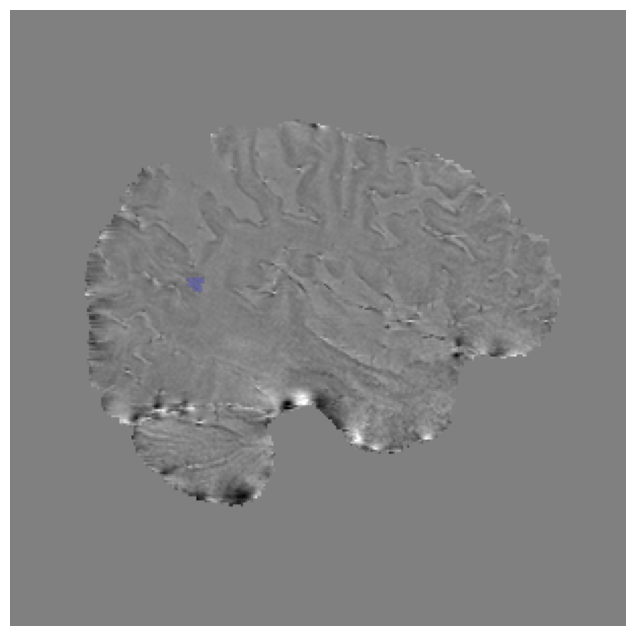

In [ ]:
plt.close('all')
example_idx = 20
img, phase, mask = train_star_data[5]
fig, axs = plt.subplots(ncols = 1,nrows=1, figsize = (8, 8))

#vis.plot_nifti_on_ax(axs, img = phase[example_idx, 0],  drop_first_label_channel=False)
vis.plot_nifti_on_ax(axs, img = phase[example_idx, 0], mask = mask[example_idx, 2], drop_first_label_channel=False, alpha_mask = 0.2)
fig.savefig("output/images/prl_on_phase.pdf", bbox_inches='tight')


# 4 - Model

## 4.1 - PRLU-Net

In [4]:
prl_unet = unet.PRLUNet(n_channels=1, n_classes=3)
n_parameters = sum(p.numel() for p in prl_unet.parameters() if p.requires_grad)
print(f"Number of parameters in the model: {n_parameters / 1e6} M")

Number of parameters in the model: 51.980803 M


# 5 - Training

# 6 - Evaluation

In [11]:
lr = 2e-4
val_pred_data = torch.load(f"output/prl_unet_lr_{lr}_last_epoch_val.pt", weights_only=False)


def to_bin(x):
    x = x > 0.5
    return x

## 6.1 - Validation metrics

In [ ]:
# for fold in range(5):
#     val_pred_data = torch.load(f"output/prl_unet_lr_{lr}_fold_{fold}_last_epoch_val.pt", weights_only=False)
#     all_labels_val = [label for _, _, label, _ in val_pred_data]
#     all_preds_val = [pred for _, _, _, pred in val_pred_data]   

#     dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
#     dice_metric(y_pred=all_preds_val, y=all_labels_val)
#     dice = dice_metric.aggregate().item()

#     true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_val, all_preds_val, channel = 2, threshold=0.5, min_lesion_diameter= 3 / 0.65)
#     print(f"Fold {fold} - TP: {true_positive}, FP: {false_positive}, FN: {false_negative}")
#     f1 = evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)
#     print(f"Fold {fold} - F1: {f1:.4f}")
#     print(f"Fold {fold} - Dice: {dice:.4f}")


Fold 0 - TP: 182, FP: 565, FN: 358
Fold 0 - F1: 0.2828
Fold 0 - Dice: 0.2758
Fold 1 - TP: 10, FP: 236, FN: 28
Fold 1 - F1: 0.0704
Fold 1 - Dice: 0.3420
Fold 2 - TP: 194, FP: 891, FN: 201
Fold 2 - F1: 0.2622
Fold 2 - Dice: 0.1733
Fold 3 - TP: 127, FP: 155, FN: 362
Fold 3 - F1: 0.3294
Fold 3 - Dice: 0.3309
Fold 4 - TP: 147, FP: 798, FN: 110
Fold 4 - F1: 0.2446
Fold 4 - Dice: 0.3030


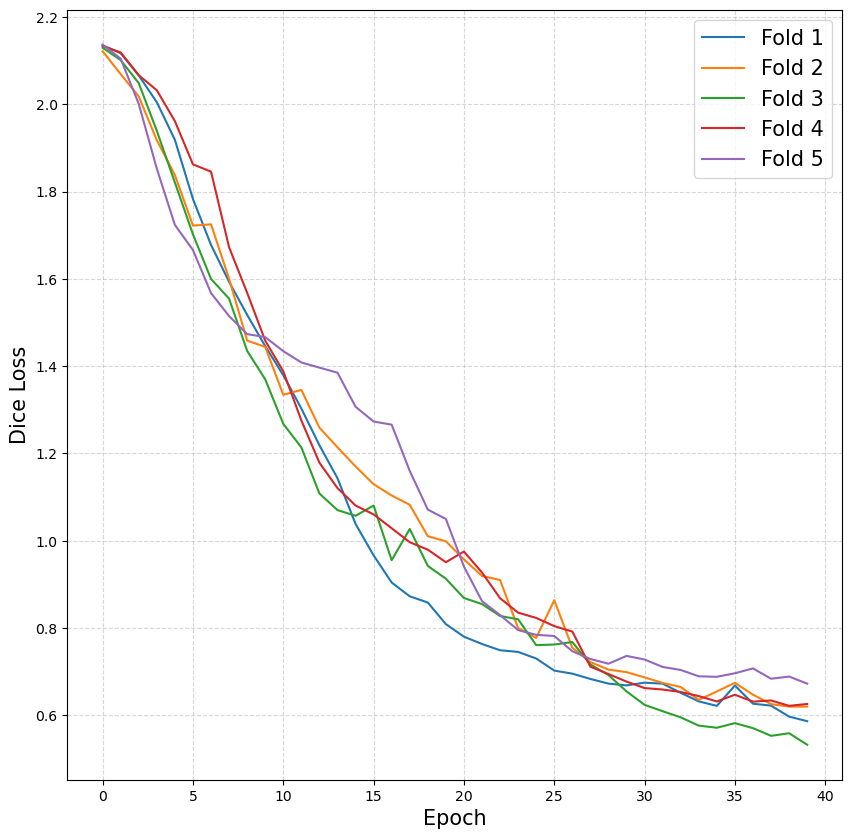

In [3]:
losses_train = [torch.load(f"output/losses_train_lr_0.0002_fold_{i}.pt", weights_only=False) for i in range(5)]
losses_val = [torch.load(f"output/losses_val_lr_0.0002_fold_{i}.pt", weights_only=False) for i in range(5)]

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (10, 10))
for i in range(5):
    axs.plot(losses_train[i], label=f"Fold {i + 1}")
    #axs.plot(losses_val[i], label=f"Fold {i + 1}")
    axs.grid(True, linestyle='--', alpha=0.5)
    axs.set_xlabel("Epoch", fontsize=15)
    axs.set_ylabel("Dice Loss", fontsize=15)
    axs.legend(fontsize=15)

plt.savefig("output/losses_train_val.pdf", bbox_inches='tight')

In [12]:
all_labels_val = [label for _, _, label, _ in val_pred_data]
all_preds_val = [pred for _, _, _, pred in val_pred_data]

In [31]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric(y_pred=all_preds_val, y=all_labels_val)
dice_score = dice_metric.aggregate().item()
print(f"Overall dice score: {dice_score}")

Overall dice score: 0.36411193013191223


In [14]:
print("PRL lesions")
true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_val, all_preds_val, channel = 2, threshold=None, min_lesion_diameter = 3 / 0.65)
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

PRL lesions
True positive: 203, False positive: 79, False negative: 190
F1 score: 0.6014814814814815


In [15]:
print("Combined")
all_labels_combined = [(label[1] + label[2]).unsqueeze(0) for label in all_labels_val]
all_preds_combined = [(pred[1] + pred[2]).unsqueeze(0) for pred in all_preds_val]
true_positive, false_positive, false_negative, n_pred_lesions, n_true_lesions = evaluation.lesion_wise_tp_fp_fn(all_labels_combined, all_preds_combined, channel = 0, threshold=None, min_lesion_diameter = 3 / 0.65, return_counts=True)
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")
print(f"Number of predicted lesions: {n_pred_lesions}, Number of true lesions: {n_true_lesions}")

Combined
True positive: 1869, False positive: 87, False negative: 41
F1 score: 0.966890843248836
Number of predicted lesions: 1956, Number of true lesions: 1751


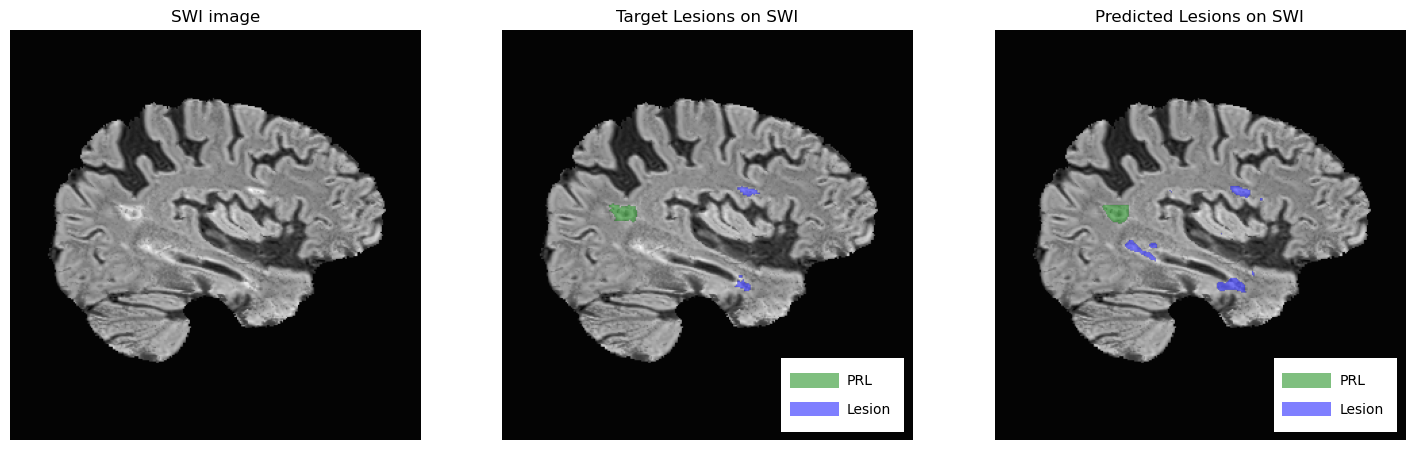

In [29]:
example_idx = 170
mag, phase, pred, label = val_pred_data[example_idx]
mag = mag.squeeze(0)
phase = phase.squeeze(0)

plt.close('all')
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 10))
vis.plot_nifti_on_ax(axs[0], img = mag, title = "SWI image")
vis.plot_nifti_on_ax(axs[1], img = mag, mask=label, title = "Target Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
vis.plot_nifti_on_ax(axs[2], img = mag, mask=pred, title = "Predicted Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
plt.show()

In [ ]:
if False:
    vis.run_prediction_app(val_pred_data)

## 6.2 - Test metrics

In [5]:
lr = 2e-4
test_pred_data = torch.load(f"output/prl_unet_lr_0.0002_last_epoch_test.pt", weights_only=False)

In [15]:
print(test_pred_data[0][0].shape, test_pred_data[0][1].shape, test_pred_data[0][2].shape, test_pred_data[0][3].shape)

torch.Size([1, 304, 304]) torch.Size([1, 304, 304]) torch.Size([3, 304, 304]) torch.Size([3, 304, 304])


In [6]:
all_labels_test = [label for _, _, label, pred in test_pred_data]
all_preds_test = [pred for _, _, _, pred in test_pred_data]

In [7]:
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric(y_pred=all_preds_test, y=all_labels_test)
dice_score = dice_metric.aggregate().item()
print(f"Overall dice score: {dice_score}")

Overall dice score: 0.29828158020973206


In [16]:
print("PRL lesions")
true_positive, false_positive, false_negative = evaluation.lesion_wise_tp_fp_fn(all_labels_test, all_preds_test, channel = 2, threshold=None, min_lesion_diameter = 3 / 0.65)  
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

PRL lesions
True positive: 49, False positive: 39, False negative: 14
F1 score: 0.6490066225165563


In [ ]:
all_lesions_t = torch.stack(all_labels_test)
print(all_lesions_t.shape)
print(len(lt.get_clusters_3d(all_lesions_t)))

torch.Size([384, 304, 304])
17


In [17]:
print("Combined")
all_labels_combined = [(label[1] + label[2]).unsqueeze(0) for label in all_labels_test]
all_preds_combined = [(pred[1] + pred[2]).unsqueeze(0) for pred in all_preds_test]
true_positive, false_positive, false_negative, n_pred_lesions, n_true_lesions = evaluation.lesion_wise_tp_fp_fn(all_labels_combined, all_preds_combined, channel = 0, threshold=None, min_lesion_diameter = 3 / 0.65, return_counts=True)
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")
print(f"Number of predicted lesions: {n_pred_lesions}, Number of true lesions: {n_true_lesions}")

#131


Combined
True positive: 322, False positive: 23, False negative: 60
F1 score: 0.8858321870701513
Number of predicted lesions: 345, Number of true lesions: 453


In [ ]:
print("Combined lesions")
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
dice_metric(y_pred=all_preds_combined, y=all_labels_combined)
dice_score = dice_metric.aggregate().item()
print(f"Overall dice score: {dice_score}")

Combined lesions
Overall dice score: 0.4550614655017853


In [ ]:
print("From Lou et al.")
true_positive = 24
false_positive = 31
false_negative = 8
print(f"True positive: {true_positive}, False positive: {false_positive}, False negative: {false_negative}")
print(f"F1 score: {evaluation.f1_from_tp_fp_fn(true_positive, false_positive, false_negative)}")

From Lou et al.
True positive: 24, False positive: 31, False negative: 8
F1 score: 0.5517241379310345


169


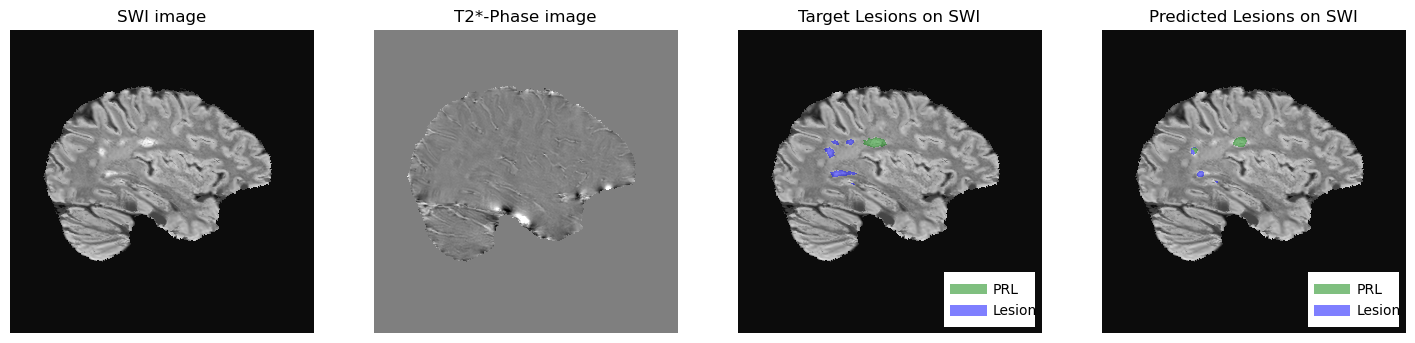

In [63]:
example_idx = 140
mag, phase, label, pred = test_pred_data[example_idx]
mag = mag.squeeze(0)
phase = phase.squeeze(0)

from pylib.imaging import lesion_tools as lt

gorups = lt.get_clusters(label[2])
for group in gorups:
    print(len(group))


plt.close('all')
fig, axs = plt.subplots(ncols = 4, nrows = 1, figsize = (18, 10))
vis.plot_nifti_on_ax(axs[0], img = mag, title = "SWI image")
vis.plot_nifti_on_ax(axs[1], img = phase, title = "T2*-Phase image")
vis.plot_nifti_on_ax(axs[2], img = mag, mask=label, title = "Target Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
vis.plot_nifti_on_ax(axs[3], img = mag, mask=pred, title = "Predicted Lesions on SWI", mask_legend=["Lesion", "PRL"], drop_first_label_channel=True)
plt.show()

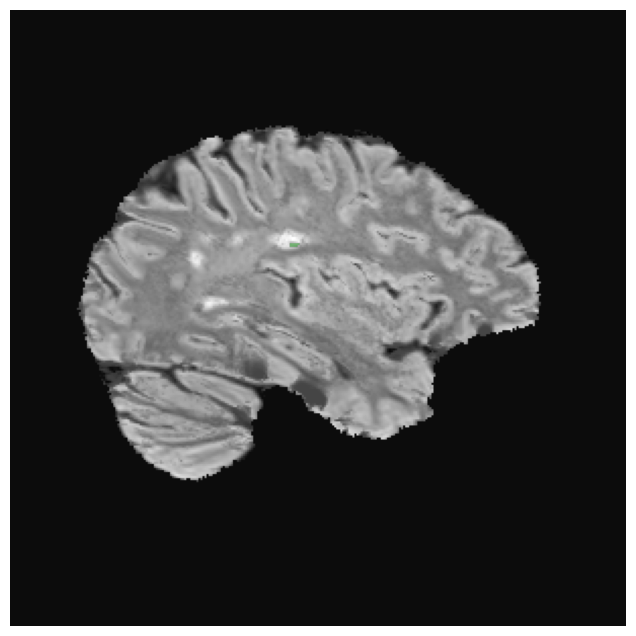

In [82]:
plt.close('all')
label[1] = torch.zeros_like(label[1])
pred[1] = torch.zeros_like(pred[1])
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 8))
vis.plot_nifti_on_ax(axs, img = mag, mask=pred, drop_first_label_channel=True)
fig.savefig("output/images/test_pred_example_pred_iou_low.pdf", bbox_inches='tight')

Intersection: 7, Union: 35
IoU score: 0.2


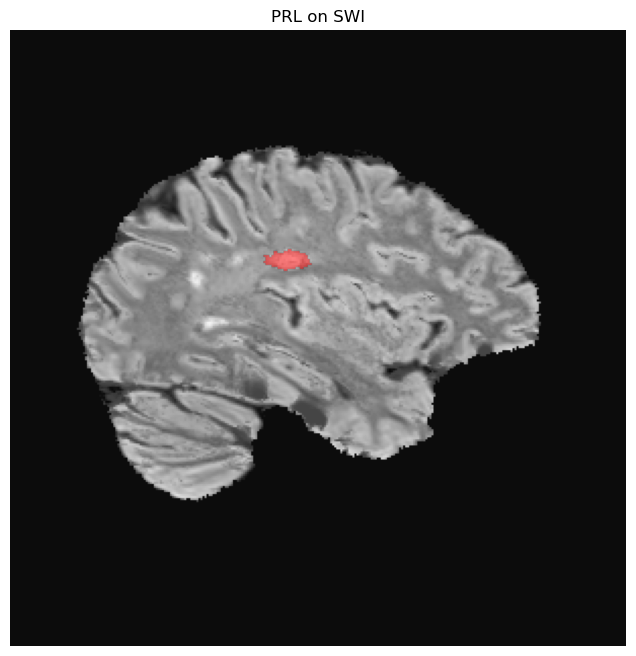

In [65]:
pred_prls = lt.get_clusters(pred[2])
target_prls = lt.get_clusters(label[2])


pred_prl = pred_prls[0]
target_prl = target_prls[0]


mask = torch.zeros_like(label)
for coord in pred_prl:
    mask[2, coord[0], coord[1]] = 1
for coord in target_prl:
    mask[1, coord[0], coord[1]] = 1

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 8))
vis.plot_nifti_on_ax(axs, img = mag, mask=mask, drop_first_label_channel=False, title = "PRL on SWI")


intersection = np.intersect1d(pred_prl, target_prl).size
union = np.union1d(pred_prl, target_prl).size
print(f"Intersection: {intersection}, Union: {union}")
print(f"IoU score: {intersection / union}")

In [ ]:
#conflicting consecutive slices 119 and 120

In [24]:
test_3d_swi = torch.stack([img for img, _, _, _ in test_pred_data])
test_3d_phase = torch.stack([phase for _, phase, _, _ in test_pred_data])
test_3d_mask = torch.stack([mask for _, _, mask, _ in test_pred_data])
test_3d_pred = torch.stack([pred for _, _, _, pred in test_pred_data])

test_imgs = [
    vis.Image3D(data=test_3d_swi, mask = test_3d_mask, title="Target lesions on SWI", image_config=vis.ImageConfig3D.DCHW),
    vis.Image3D(data=test_3d_swi, mask = test_3d_pred, title="Predicted lesions on SWI", image_config=vis.ImageConfig3D.DCHW),
 ]

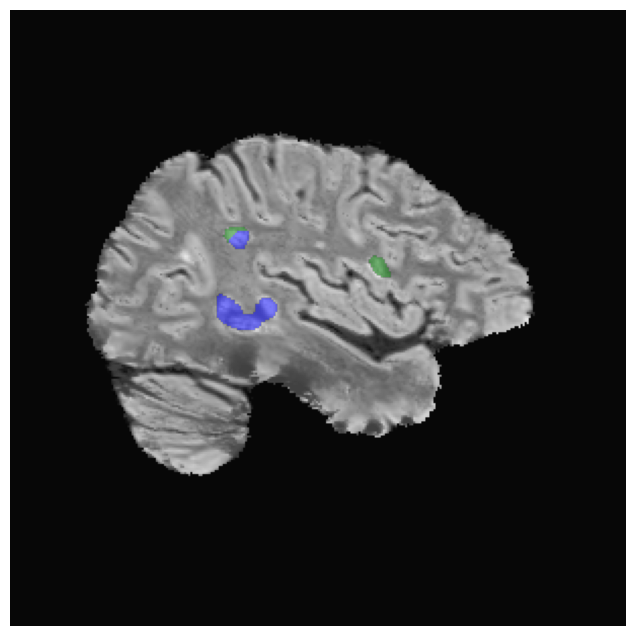

In [29]:
fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 8))
vis.plot_nifti_on_ax(axs, img = test_3d_swi[147, 0], mask=test_3d_pred[147], drop_first_label_channel=True)
plt.savefig("output/images/test_swi_confluent_pred.pdf", bbox_inches='tight')

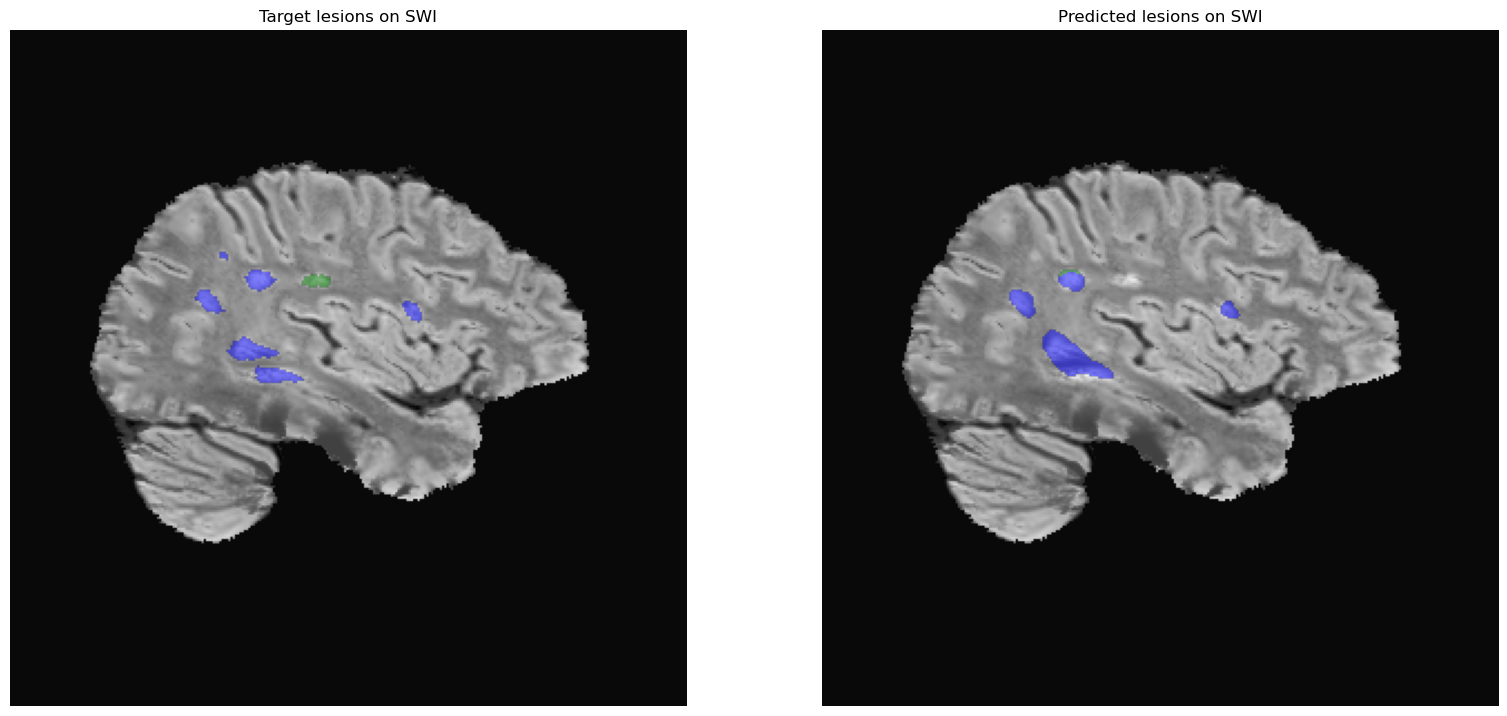

In [25]:
vis.run_app(
    image_3d = test_imgs
)

### 6.3 Evaluation 3D

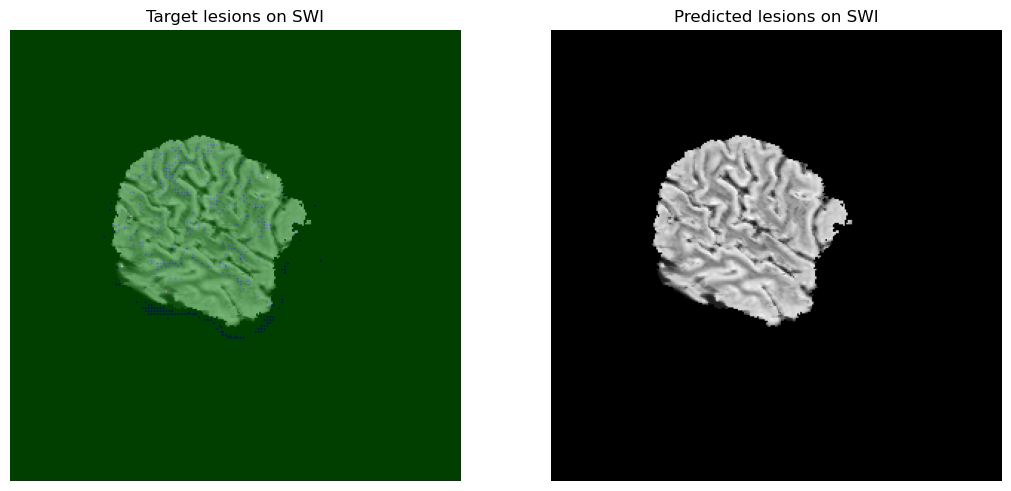

In [ ]:
test_3d_data = torch.load(f"output/prl_unet_3d_lr_{lr}_last_epoch_val.pt", weights_only=False)

vis.run_app([
    vis.Image3D(data=test_3d_data[0][0], mask = test_3d_data[0][2], title="Target lesions on SWI", image_config=vis.ImageConfig3D.CDHW),
    vis.Image3D(data=test_3d_data[0][0], mask = test_3d_data[0][3], title="Predicted lesions on SWI", image_config=vis.ImageConfig3D.CDHW)
])

# 7 - References

* Lou, , Sati, P., Absinta, M., Clark, K., Dworkin, J. D., Valcarcel, A. M., Schindler, M. K., Reich, D. S., Sweeney, E. M., & Shinohara, R. T. (2020). Fully automated detection of paramagnetic rims in multiple sclerosis lesions on 3T susceptibility-based MR imaging. *bioRxiv*. https://doi.org/10.1101/2020.08.31.276238

* Dymerska, B., Eckstein, K., Bachrata, B., Siow, B., Trattnig, S., Shmueli, K., Robinson, S.D., (2020). Phase Unwrapping with a Rapid Opensource Minimum Spanning Tree AlgOrithm (ROMEO). Magnetic Resonance in Medicine. https://doi.org/10.1002/mrm.28563